## ROC AUC Threshold
https://realpython.com/python-histograms/<br />
https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5<br />
https://medium.com/greyatom/lets-learn-about-auc-roc-curve-4a94b4d88152<br />
https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8<br />
https://www.science-emergence.com/Articles/How-to-use-the-ROC-curve-to-test-the-performance-of-a-discrete-classifier-in-python-/

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

%matplotlib inline

In [2]:
# Create dataset
n = 1000
f = 2
inform = 2
features, binary_class = make_classification(n_samples=n, n_features=f,  
                                             n_informative=inform, n_redundant=0, 
                                             n_clusters_per_class=1, random_state=13)

# Create a dataframe of the features and add the binary class (label, output)
df = pd.DataFrame(features)
df.columns = ['Feature_1', 'Feature_2']
df['Target'] = binary_class
df.head()

,Feature_1,Feature_2,Target
0,-1.355723,0.932216,0
1,-1.448966,0.628289,0
2,-0.259349,-0.792658,0
3,0.815272,-0.205096,1
4,1.430197,1.342170,1


In [3]:
# X_train, X_test split
X = df.drop('Target', axis=1)
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [4]:
# Create model
model = LogisticRegression(solver='lbfgs')
model.fit(X_train,y_train)
predictions = model.predict(X_test)

In [5]:
# View confusion matrix, classification report, and auc
tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
print('Confusion Matrix')
print(confusion_matrix(y_test,predictions))
print()
print('Classification Report')
print(classification_report(y_test,predictions))
fpr, tpr, thresholds =roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

total = tn + fp + fn + tp
fpr = fp/(tn+fp)
tpr = tp/(fn+tp)

Confusion Matrix
[[83 15]
 [ 9 93]]

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.85      0.87        98
           1       0.86      0.91      0.89       102

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.88       200
weighted avg       0.88      0.88      0.88       200

Area under the ROC curve : 0.879352


In [6]:
# Compare with crosstab
pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'],margins=True)

Predicted,0,1,All
Actual,,,
0,83,15,98
1,9,93,102
All,92,108,200


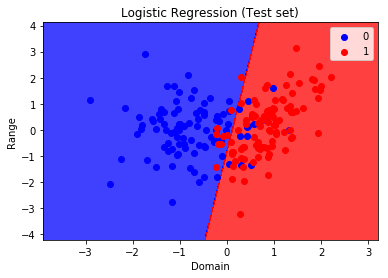

In [7]:
# Visuale the test set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, model.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('blue', 'red')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('blue', 'red'))(i), label = j)
plt.title('Logistic Regression (Test set)')
plt.xlabel('Domain')
plt.ylabel('Range')
plt.legend()
plt.show()

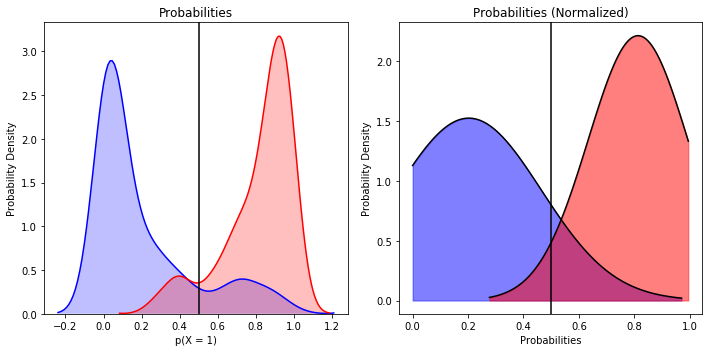

In [8]:
# Compare KDE plots for probabilities and normed probabilities
import warnings
warnings.filterwarnings('ignore')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

probs=model.predict_proba(X_test)[:,1]
sns.kdeplot(probs[y_test==0], shade=True, color='b', Label='Target: 0', ax=ax1);
sns.kdeplot(probs[y_test==1], shade=True, color='r', Label='Target: 1', ax=ax1);
ax1.axvline(x=.5,color='black')
ax1.set_title('Probabilities')
ax1.set(xlabel='p(X = 1)', ylabel='Probability Density')

mean = probs[y_test==0].mean() 
std = probs[y_test==0].std()
x = np.linspace(probs[y_test==0].min(), probs[y_test==0].max(), 100)
y = scipy.stats.norm.pdf(x,mean,std)
ax2.plot(x,y, color='black')
ax2.fill_between(x, y, color='blue', alpha='0.5')

mean = probs[y_test==1].mean() 
std = probs[y_test==1].std()
x = np.linspace(probs[y_test==1].min(), probs[y_test==1].max(), 100)
y = scipy.stats.norm.pdf(x,mean,std)
ax2.plot(x,y, color='black')
ax2.fill_between(x, y, color='red', alpha='0.5')

x_threshold = 0.5
ax2.axvline(x=x_threshold,color='black')

ax2.set_title('Probabilities (Normalized)')
ax2.set(xlabel='Probabilities', ylabel='Probability Density')

plt.tight_layout()

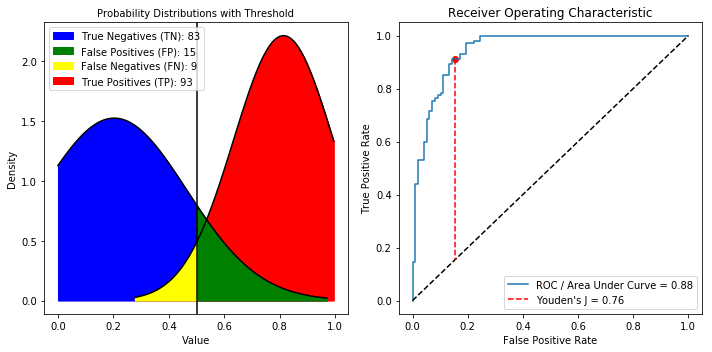

In [9]:
# Visualize TN, FN, FP, TP, ROC, and Youden's J
from scipy.integrate import quad
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import math
import matplotlib.patches as mpatches

def calculateDistance(x1,y1,x2,y2):
    dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist

def normal_distribution_function(x,mean,std):
    value = scipy.stats.norm.pdf(x,mean,std)
    return value

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

x_threshold = 0.5
ax1.axvline(x=x_threshold,color='black')

ax1.set_title('Probability Distributions with Threshold',fontsize=10)

mean_0 = probs[y_test==0].mean() 
std_0 = probs[y_test==0].std()
x_0 = np.linspace(probs[y_test==0].min(), probs[y_test==0].max(), 100)
y_0 = scipy.stats.norm.pdf(x_0,mean_0,std_0)
ax1.plot(x_0, y_0, color='black')
ax1.fill_between(x_0, y_0, color='blue', alpha='1.0')

mean = probs[y_test==1].mean() 
std = probs[y_test==1].std()
x = np.linspace(probs[y_test==1].min(), probs[y_test==1].max(), 100)
y = scipy.stats.norm.pdf(x,mean,std)
ax1.plot(x,y, color='black')
ax1.fill_between(x, y, color='red', alpha='1.0')

ptx_0 = np.linspace(x_threshold, probs[y_test==0].max(), 100)
pty_0 = scipy.stats.norm.pdf(ptx_0,mean_0,std_0)
ax1.fill_between(ptx_0, pty_0, color='green', alpha='1.0')

ptx = np.linspace(probs[y_test==1].min(), x_threshold, 100)
pty = scipy.stats.norm.pdf(ptx,mean,std)
ax1.fill_between(ptx, pty, color='yellow', alpha='1.0')

tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
tn_patch = mpatches.Patch(color='blue', label='True Negatives (TN): ' + str(tn))
fp_patch = mpatches.Patch(color='green', label='False Positives (FP): ' + str(fp))
fn_patch = mpatches.Patch(color='yellow', label='False Negatives (FN): ' + str(fn))
tp_patch = mpatches.Patch(color='red', label='True Positives (TP): ' + str(tp))
ax1.legend(handles=[tn_patch,fp_patch,fn_patch,tp_patch], loc=2)
ax1.set(xlabel='Value', ylabel='Density')

# tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
optimum_fpr = fp/(tn+fp)
optimum_tpr = tp/(fn+tp)
# print('Youden\'s J = tpr - fpr = {:.2f}'.format(optimum_tpr - optimum_fpr) )

logit_roc_auc = roc_auc_score(y_test, predictions)
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
ax2.plot(fpr, tpr, label='ROC / Area Under Curve = %0.2f' % logit_roc_auc)
ax2.plot([0, 1], [0, 1],'k--')
ax2.scatter(optimum_fpr, optimum_tpr, c='red')
ax2.plot([optimum_fpr, optimum_fpr], [optimum_tpr, optimum_fpr], 'r--', label='Youden\'s J = %0.2f' 
         % calculateDistance(optimum_fpr, optimum_fpr, optimum_tpr, optimum_fpr))
ax2.set_title('Receiver Operating Characteristic')
ax2.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
ax2.legend(loc="lower right")

plt.tight_layout()

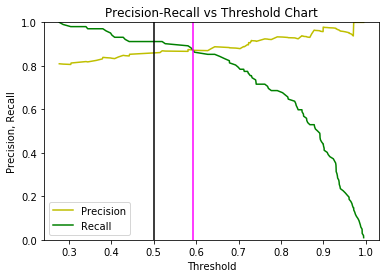

In [10]:
# Compare precision-recall and two thresholds
# https://stackoverflow.com/questions/28716241/controlling-the-threshold-in-logistic-regression-in-scikit-learn

from sklearn.metrics import precision_recall_curve, auc
precision, recall, thresholds = precision_recall_curve(y_test, probs) 
pr_auc = auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "y-", label="Precision")
plt.plot(thresholds, recall[: -1], "g-", label="Recall")
x_threshold = 0.5
plt.axvline(x=x_threshold,color='black')
plt.axvline(x=thresholds[np.where(recall == recall[precision == recall])][-1],color='magenta')
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])
plt.show()

In [11]:
# X value where precision and recall cross
print(recall[precision == recall])
print(np.where(recall == recall[precision == recall]))
print(thresholds[np.where(recall == recall[precision == recall])])

[0.87254902]
(array([24]),)
[0.59239728]


In [12]:
# View confusion matrix with new threshold
tuned_predictions = np.where(probs > thresholds[np.where(recall == recall[precision == recall])][-1], 1, 0)
confusion_matrix(y_test, tuned_predictions)

array([[85, 13],
       [14, 88]])

In [13]:
# Compared with original confusion matrix
confusion_matrix(y_test, predictions)

array([[83, 15],
       [ 9, 93]])